In [1]:
import copy
import pandas as pd
import numpy as np

import datetime as dt
import random
import time
import math
import itertools

#import statsmodels.api as sm

from IPython.display import clear_output


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from graphviz import Digraph
from scipy.ndimage import shift
#import pydot


from k2_alg import k2 
from k2_alg import gen_clean_df

from scikit_alarm_framework.alarm_generator import set_point

Requirement already up-to-date: pip in /home/rute/anaconda3/lib/python3.7/site-packages (18.1)


In [4]:
#instalacao sckit alarm
from getpass import getpass

import os

os.environ['GITHUB_AUTH'] = getpass('GitHub user') + ':' + getpass('GitHub password')
!pip -q install -e git+https://${GITHUB_AUTH}@github.com/abugim/scikit-alarm-framework.git@develop#egg=scikit-alarm-framework


GitHub user········
GitHub password········


In [6]:
# https://pypi.python.org/pypi/pydot
!pip install graphviz

In [7]:
!pip install --upgrade pip


Requirement already up-to-date: pip in /home/rute/anaconda3/lib/python3.7/site-packages (18.1)


In [5]:
def get_lim_index(cdf, lim):
    summation = 0
    index = 0
    for i in np.arange(0, cdf.size):
        if cdf[i] > lim:
            index = i
            break
    return index 

In [8]:
def surrogate(a):
    a_diff = np.diff(a)
    begin = np.where(a_diff > 0)[0]
    end = np.where(a_diff < 0)[0]
    
    if begin.size > end.size:
        end = np.append(end, a.size)
    elif begin.size < end.size:
        begin = np.insert(begin, 0, 0) 
    elif begin.size == 0 and end.size == 0:
        return a.copy()
    elif np.all(begin > end):
        begin = np.insert(begin, 0, 0)
        end = np.append(end, a.size)
    
    n_seq = np.max([begin.size, end.size])
    a_surr = np.zeros(a.shape)
    p_seq = np.random.randint(0, a.size - max(end - begin), size=n_seq)
    for i in np.random.permutation(n_seq):
        len_seq = end[i] - begin[i]
        a_surr[p_seq[i]:p_seq[i] + len_seq] = a[begin[i]:end[i]]
    return a_surr

In [9]:
#Method using stats model kde to return transfer etnropy value limit. That is, the 'x' value corresponding to P95
def significance_test(k,l,h,sup_lim, n, a,b):
    '''
        significance_test(a,b,k,l,h,sup_lim, n)
    '''
    transferEntropies = []    
    
    np.random.seed(int(time.time()))
    for i in np.arange(0,n):
        surrogate_a = surrogate(a.copy())
        transferEntropies.append(te(k,l,h,surrogate_a[:],b, 'serie_a', 'serie_b'))
        
    kde = sm.nonparametric.KDEUnivariate(transferEntropies)
    kde.fit()
    
    
    lvl_sig = kde.icdf[get_lim_index(kde.cdf, sup_lim)]
    return lvl_sig

In [10]:
##for paper test
def joint_probability_new(k,l,h, a, b, lbl_a, lbl_b):
    '''
        k B time horizon
        l A time horizon
        h instant in the future of serie B
        
        
        a, b array type'''
    
    numStates=2**(k+l+1)
    combinations = list(map(list, itertools.product([0, 1], repeat=k+l+1)))
    prob_cnjt = np.zeros(numStates)
    
    #Alarm Series A (cause), B (effect), same len
    #teste   

    matrix_nova = np.matrix([b[1:],b[:-1],a[:-1]]).T
    df = pd.DataFrame(matrix_nova, columns = ['b_ftr', lbl_b, lbl_a])
    gpd = df.groupby(['b_ftr', lbl_b, lbl_a], as_index=False).size().reset_index(name='Count')
    total = sum(gpd['Count'])
    
    for i in np.arange(0,gpd.shape[0]):
        comb = [e for e in gpd.iloc[i][0:3].values.tolist()]
        idx = combinations.index(comb)
        prob_cnjt[idx] = gpd.iloc[i]['Count']/total

    return prob_cnjt

In [11]:
def joint_probability(k,l, h, a, b):
    '''
        k B time horizon
        l A time horizon
        h instant in the future of serie B
        
        a, b array type'''

    #Alarm Series A (cause), B (effect), same len
    #tested
    sizeSeries = a.size
    transEntropy = 0
    numStates = 2**(k + l  + 1)
    combinations = list(map(list, itertools.product([0, 1], repeat=k+l+1)))
    counting = np.zeros(numStates)
    prob_cnjt = np.zeros(numStates)
    a_prob_ind = []
    b_prob_ind = []
    #joitn probability p(i_sub_t+1), i_sub_t**k, j_sub_t**l)
    inicio = np.max([k,l]) - 1
    for i in np.arange(inicio, sizeSeries - h):
        for hk in np.arange(0,k):
                b_prob_ind.append(b[i - hk])
        for hl in np.arange(0,l):
                a_prob_ind.append(a[i - hl])

        #print(a.size, b.size, a.size -1)     
        ab = [b[i + h]] + b_prob_ind + a_prob_ind 
        index_comb = combinations.index(ab)
        counting[index_comb] = counting[index_comb] + 1

        a_prob_ind = []
        b_prob_ind = []

    total = sum(counting)
  
    prob_cnjt = counting/total
     
    return prob_cnjt

In [12]:
#Joint probability evaluation p(i_t+h, i_t**k)
#tested
def joint_prob_ih_ik(k,l, joint_prob_ih_ik_jl):
    states_ith_ik = list(map(list, itertools.product([0, 1], repeat=k + 1)))
    combinations = list(map(list, itertools.product([0, 1], repeat=k+l+1))) 
    p_jnt_ith_ik = np.zeros(2**(k+1))
    
    for i, state in enumerate(states_ith_ik):
        for j, comb in enumerate(combinations):
            if comb[0:k+1] == state:
                p_jnt_ith_ik[i] = p_jnt_ith_ik[i] + joint_prob_ih_ik_jl[j]
    return p_jnt_ith_ik

In [13]:
def conditional_prob(k,l,joint_prob):
    states = list(map(list, itertools.product([0, 1], repeat=k+l)))
    combinations = list(map(list, itertools.product([0, 1], repeat=k+l+1)))

    size = int(joint_prob.size/2)
    conditional = np.zeros(2**(k+l+1))

    for i,state in enumerate(states):
        index_zero = combinations.index([0] + state)
        prob_zero = joint_prob[index_zero]

        index_one = combinations.index([1] + state)
        prob_one = joint_prob[index_one]

        if(prob_zero + prob_one != 0):
            conditional[i] = prob_zero/(prob_zero+ prob_one)
            conditional[i + 2**(k+l)] = prob_one/(prob_zero+ prob_one)
    return conditional

In [14]:
#Division of the conditionals in log2 
#tested
def conditional_div(k,l,conditional_num, conditional_den):
    combinations = list(map(list, itertools.product([0, 1], repeat=k+l+1)))
    conditional_division = np.zeros(conditional_num.size)
    states_den = list(map(list, itertools.product([0, 1], repeat=1+k)))
    for j, comb in enumerate(combinations):
        if(conditional_den[states_den.index(comb[0:k+1])] != 0):
            conditional_division[j] = conditional_num[j]/conditional_den[states_den.index(comb[0:k+1])]            
    return conditional_division

In [15]:
#Transfer entropy final evaluation
def te(k,l,h_window, a,b):
    '''
        transentropy a->b
        te(k,l,h,a,b)
        k - dimension of b
        l - dimension of a
        h -> instant in the future of a
    '''
    #joint_p_ih_ik_jl = joint_probability_new(k,l,h,a,b, lbl_a, lbl_b)
    
    te_by_h = []
    for h in np.arange(1,h_window):
      joint_p_ih_ik_jl = joint_probability(k,l,h,a,b)

      joint_p_ih_ik = joint_prob_ih_ik(k,l, joint_p_ih_ik_jl)
      conditional_num = conditional_prob(k,l,joint_p_ih_ik_jl)
      conditional_den = conditional_prob(k,0, joint_p_ih_ik)    
      div = conditional_div(k,l,conditional_num, conditional_den)

      #log2 from the division of the conditionals -> #p(i_sub_t+h|i_sub_t**k, j_sub_t**l) /p(i_sub_t+h|i_t**k)
      log2_div_cond = np.log2(div[div!=0])
      te = np.sum(joint_p_ih_ik_jl[div!=0]*log2_div_cond)
      
      te_by_h.append(te)
      
     #adpatacao para calcular 20 minutos e 30 minutos de janela ao mesmo tempo
      te_by_h33 = te_by_h[0:33]
      lag = np.argmax(te_by_h) + 1
      lag33 = np.argmax(te_by_h33) + 1
    return [max(te_by_h33), max(te_by_h),lag33, lag]

In [16]:
def transferEntropy_case(dist_df, h, k, l):
    #start = time.clock()   
    #------------adaptcao para retornar transentropy de meia hora e de 20 min---------
    
    transEntropy33 = np.zeros([dist_df.columns.size,dist_df.columns.size])
    lagEntropy33 = np.zeros([dist_df.columns.size,dist_df.columns.size])
    
    transEntropy = np.zeros([dist_df.columns.size,dist_df.columns.size])
    lagEntropy = np.zeros([dist_df.columns.size,dist_df.columns.size])
    
    sigValues =  np.zeros([dist_df.columns.size,dist_df.columns.size])
    for i in np.arange(0, dist_df.columns.size):
        for j in np.arange(0, dist_df.columns.size):
            print('trans ', dist_df.columns[i], dist_df.columns[j])
            if(j != i + dist_df.columns.size/2 and j!=i and j != i - dist_df.columns.size/2):
                te_result = te(k,l,h, dist_df[dist_df.columns[i]], dist_df[dist_df.columns[j]])
                transEntropy33[i][j] = te_result[0]
                lagEntropy33[i][j] = te_result[2]
                
                transEntropy[i][j] = te_result[1]
                lagEntropy[i][j] = te_result[3]
                
            clear_output()
    #end = time.clock()   
    
    #print(end - start)
    return [transEntropy33, lagEntropy33, transEntropy,lagEntropy]  

In [17]:
def apply_roll_mean(df, window):
    roll  = df.copy().rolling(window).mean() 
    roll.dropna(inplace=True)
    roll = roll.round(decimals=0).copy()
    roll.reset_index(drop=True, inplace=True)
    return roll

In [18]:
def graph_simple(df, eng = 'dot'):
    edge_style = ""
    g = Digraph(engine=eng)
    in_graph = []
    for k, row in enumerate(df.index):
        if any(df.loc[row]):
            g.node(str(row),row, shape='oval', fontsize='10', width='0', style='filled', fillcolor='#c9c9c9', color="gray")
            in_graph.append(row)

              
    for c, col in enumerate(df.columns):
        if any(df[col]):
            if col not in in_graph:
                g.node(str(col), col, shape='oval', fontsize='10', width='0', style='filled', fillcolor='#c9c9c9', color="gray") 

    for j, col in enumerate(df.columns):
        for i, row in enumerate(df.index):
            if(df[col][i]):
                g.edge(str(row), str(col), label=str(df.at[row,col]), style= edge_style, color='black')  
    return g 

In [19]:
def graph(df, df_lag, eng = 'dot'):
    edge_style = ""
    g = Digraph(engine=eng)
   
    for k, row in enumerate(df.index):
        if any(df.iloc[k]) or any(df[row]):
            g.node(str(k),row, shape='oval', fontsize='10', width='0', style='filled', fillcolor='#c9c9c9', color="gray") 

    for j, col in enumerate(df.columns):
        for i, row in enumerate(df[col]):
            if(row):
                te_val  = str(np.round(row, 6))
                g.edge(str(i), str(j), label=str(df_lag[df_lag.columns[j]][i]),style= edge_style, color='dark')  
    return g 

In [20]:
def graph_from_dict(dictionary, eng = 'dot'):
    edge_style = ""
    g = Digraph(engine=eng)
   
    for k, i in dictionary.items():
        g.node(str(k),k, shape='oval', fontsize='10', width='0', style='filled', fillcolor='#c9c9c9', color="gray") 
        df_te.m
    for k, i in dictionary.items():
        for it in i:
            g.edge(str(it), str(k), label='',style= edge_style, color='dark')  
    return g 

In [21]:
def generate_df_valid_corrs(df, limit):
    df_valid = df.copy()
    for row in df.columns:
        for col in df.columns:
            if df[row][col] < limit:
                df_valid[row][col] = 0
                
    return df_valid 

In [22]:
def generate_df_max_info(df):
    df_max_info = pd.DataFrame(data = np.zeros([len(df),len(df)]),columns=df.columns, index = df.columns)
    for  i,col in enumerate(df.columns):
        sort = df[col].sort_values(ascending=False)
        df_max_info.loc[sort.index[0]][i] = sort[0]
    return df_max_info
    

In [23]:
def apply_first_diff(df):
    dist_diff = df.diff()
    dist_diff.clip(lower=0, inplace=True)
    dist_diff.dropna(inplace=True)
    dist_diff.reset_index(drop=True, inplace=True)
    dist_diff = dist_diff.astype(int)
    
    return dist_diff

In [24]:
def rm_smtc_cicle(df):
    rm_df = df.copy()
    for c, col in enumerate(rm_df.columns):
        for r, row in enumerate(rm_df[col]):
            simetric_val = rm_df[rm_df.columns[r]][c]
            if row and simetric_val:
                if simetric_val >= row:
                    rm_df[col][r] = 0
                else:
                    simetric_val = 0
    return rm_df
                

In [25]:
def get_ancestrals(lista, node, lista_nova):
    
    if not node in lista_nova:
        lista_nova.extend([node])
            
    if not lista[node] or np.all(np.unique(lista[node]) == ['x']):
        return lista_nova
    else:
        for i,no in enumerate(lista[node]): 
            if no == 'x':
                continue
            idx = no
            node_to_list = [lista[node][i]]
            lista[node][i] = 'x'
           
            if 'x' in lista[no]:
                get_ancestrals(lista, idx, lista_nova)   
            elif not lista[no]:
                lista_nova.extend(node_to_list)
                lista[no] = ['x']
                continue
            else:
                lista_nova.extend(node_to_list)
                get_ancestrals(lista, idx, lista_nova)             
        else:
            return get_ancestrals(lista, node, lista_nova)

In [26]:
lista= [[],[0],[0,1],[2]]
get_ancestrals(lista, 2, [])

/home/rute/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


[2, 0, 1]

In [27]:
def generate_aciclic_graph(grafo_param):
    graph_mat = copy.deepcopy(grafo_param)
    grafo_ac = np.zeros([len(graph_mat), len(graph_mat)], dtype=float)
    ancestrals = [[] for el in np.arange(0, len(graph_mat))]
    
    max_val = max(graph_mat.flatten().tolist())
    idx_max = np.argmax(graph_mat.flatten().tolist())  

    while(max_val > 0):
        idx_row = int(np.floor(idx_max)/len(graph_mat))
        idx_col = idx_max - len(graph_mat)*idx_row

        impossible_nodes = []
        if ancestrals[idx_row]:
            impossible_nodes = get_ancestrals(copy.deepcopy(ancestrals),idx_row, [])
            if not idx_col in impossible_nodes:
                grafo_ac[idx_row, idx_col] = graph_mat[idx_row, idx_col]
                ancestrals[idx_col] += [idx_row] 
        else:
            ancestrals[idx_col] += [idx_row]
            grafo_ac[idx_row,idx_col] = max_val

        graph_mat[idx_row, idx_col] = 0
        max_val = max(graph_mat.flatten().tolist())
        idx_max = np.argmax(graph_mat.flatten())
    return grafo_ac

In [28]:
def get_lags_ances(mat, idx, soma, lista_lags, ref):
    
    if np.all(mat[:,idx] == np.zeros(len(mat))):
        mat[idx] =  [-1 for peso in mat[idx]]
        return 0

    for i,dad_lag in enumerate(mat[:,idx]):
        if dad_lag != 0:
            if not np.all(mat[i] == [-1 for peso in mat[i]]):
                soma += dad_lag
                lista_lags.append((str(i), soma))
                get_lags_ances(mat, i, soma, lista_lags, ref)
                
                soma = 0
    return lista_lags
        
        
    

In [29]:
def get_lags_ances_df(df, idx, soma, dict_lags, lista, dict_caminhos):
    lista.append(idx)
    if np.all(df[idx] == np.zeros(len(df))):
        return [dict_lags,dict_caminhos]
    for i,dad_lag in enumerate(df[idx]):
        if dad_lag > 0:
          
            soma += dad_lag
            try:
                dict_lags[df.columns[i]].append(soma)
                dict_caminhos[df.columns[i]].append(lista)
            except:
                dict_lags[df.columns[i]] = [soma]
                dict_caminhos[df.columns[i]]= [lista]
        
            get_lags_ances_df(df, df.columns[i], soma, dict_lags, lista[:], dict_caminhos)
            soma -= dad_lag
            
    return [dict_lags, dict_caminhos] 

In [30]:
def get_all_shifts(nodes, df):
    dic = {}
    for node in nodes:
        df_cp = df.copy()
#         if not np.all(mat_cp[node] == np.zeros(len(mat_cp))):
        dic[node] = get_lags_ances_df(df_cp, node, 0, {}, [],{})[0]
    return dic

In [31]:

def gen_tree_from_lags(dici):
    tree_k2 = {}
    for key_son, value in dici.items():    
        if value:
            for key_dad, value_dad in value.items():
                for i, value in enumerate(value_dad):
                    try:
                        tree_k2[key_son].append(key_dad+"-"+str(i)+"_"+str(int(value)))
                    except:
                         tree_k2[key_son] = [key_dad+"-"+str(i)+"_"+str(int(value))]
                            
                    tree_k2[key_dad+"-"+str(i)+"_"+str(int(value))] = []
        else:
            tree_k2[key_son] = []
    return tree_k2  
        


In [32]:
def gen_df_iteration(df, node, dict_lag):
    df_gen = df.copy()
    if dict_lag[node]:
        for key_dad, values_dad in dict_lag[node].items():
            for i, val in enumerate(dict_lag[node][key_dad]): 
                df_gen[key_dad+"-"+str(i)+"_"+str(int(val))] = shift(df_gen[key_dad], int(val), order=0, mode='constant', cval=np.NaN)
    df_gen.dropna(inplace=True)
    return df_gen


In [33]:
def apply_methodlogy(df_te, df_lag, dist):
    
    t = np.mean(df_te.values) + 3*np.std(df_te.values)

    #aplicar threshold
    te_vld = generate_df_valid_corrs(df_te, t)
    #remover ciclos
    te_vld_no_cycle = pd.DataFrame (data = generate_aciclic_graph(te_vld.values), columns=te_vld.columns, index=te_vld.columns)

    #passar a utilizar o grafo de lags ao invés do de TE

    te_vld__lags_no_cycle = df_lag[te_vld_no_cycle > 0].fillna(0)

    #computar todos os ancestrais (comuns e virtuais)

    dict_ancestors = get_all_shifts(te_vld__lags_no_cycle.columns, te_vld__lags_no_cycle)


    #gerar arvore do k2
    k2_tree = gen_tree_from_lags(dict_ancestors)

    #gerar calcular k2

    k2_result = k2(dist, k2_tree, te_vld__lags_no_cycle, 0.7)

    #reconstruir grafo

    k2_rebuild = gen_clean_df(te_vld__lags_no_cycle, k2_result)

    #trocar valores do k2 rebuild pelos lags corretos

    graph_final = te_vld__lags_no_cycle[k2_rebuild>0].fillna(0)
    return graph_final

In [35]:
dist6 = pd.read_csv("dist6_3horas_sig/alm_seq.csv")
dist = dist6[['xmeas%02d_low' % x for x in [1,2,3,6,7,8,9,21]] + ['xmeas%02d_high' % x for x in [1,2,3,6,7,8,9,21]]]

df_mean5 = apply_roll_mean(dist, 5)
df_mean5.to_csv("resultados_defesa/alm_seq_m5.csv")

In [36]:
#-----------geracao dos alarmes para novo dataset----

#data processo
dist6_novo_proc = pd.read_csv("resultados_defesa/dist6_1_10.csv")
dist_novo = dist6_novo_proc[['XMEAS%02d' % x for x in [1,2,3,6,7,8,9,21]]]

thresh_high = [0.284,3711.109,4514.069,48.235,2803.033,66.505,122.932,102.527]
thresh_low =  [0.249,3597.394,4371.271,46.954,2796.971,63.494,122.867,102.409]


#--------------geracao dos alarmes------------
high_alarms = set_point.generate(dist_novo, thresh_high)
low_alarms = set_point.generate(dist_novo, thresh_low, high=False)

#------------------renomenado as colunas-------------

high_names = ['x%01d_high' % var for var in [1,2,3,6,7,8,9,21]]
low_names =  ['x%01d_low'  % var for var in [1,2,3,6,7,8,9,21]]

rename_high = {key:value for key, value in zip(high_alarms.columns,high_names)}
rename_low = {key:value for key, value in zip(low_alarms.columns,low_names)}

high_alarms = high_alarms.rename(rename_high, axis='columns')
low_alarms = low_alarms.rename(rename_low, axis='columns')

#----------------------contenando os dois tipos de alrme---------------

dist6_novo_alm =  pd.concat([high_alarms, low_alarms], axis=1)
dist6_novo_alm.to_csv('resultados_defesa/dist6_novo_alm.csv')

In [37]:
#aplicacao da média movel

dist6_novo_alm_mean5 = apply_roll_mean(dist6_novo_alm, 5)
dist6_novo_alm_mean5.to_csv("resultados_defesa/almseq_m5_novo.csv")


In [40]:
te_matrix11_novo = transferEntropy_case(dist6_novo_alm_mean5, 50,1,1)

In [41]:
#-----------janela de 20 min--------------------------------------------------------
t33 = np.mean(te_matrix11_novo[0]) + 3*np.std(te_matrix11_novo[0])

df_te_11_33 = pd.DataFrame(te_matrix11_novo[0], columns = dist6_novo_alm.columns, index= dist6_novo_alm.columns)
df_te_lag_11_33 = pd.DataFrame(te_matrix11_novo[1], columns = dist6_novo_alm.columns, index= dist6_novo_alm.columns)

#---------salvando te e lags----------
df_te_11_33.to_csv("resultados_defesa/df_te_novo33_k1l1.csv")
df_te_lag_11_33.to_csv("resultados_defesa/df_lags_novo33_k1l1.csv")

df_result_33 = apply_methodlogy(df_te_11_33,df_te_lag_11_33, dist6_novo_alm_mean5)

/home/rute/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


here  x6_low x1_high
here  x6_low x7_high
here  x6_low x9_high
here  x21_high x6_low
here  x21_high x7_low
here  x21_high x21_low


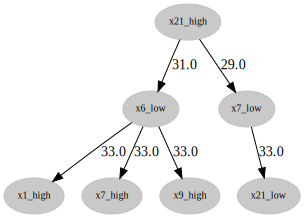

In [42]:
graph_simple(df_result_33)

In [43]:
# janela de 30 min
t50 = np.mean(te_matrix11_novo[2]) + 3*np.std(te_matrix11_novo[2])

df_te_50 = pd.DataFrame(te_matrix11_novo[2], columns = dist6_novo_alm.columns, index= dist6_novo_alm.columns)
df_te_lag_50 = pd.DataFrame(te_matrix11_novo[3], columns = dist6_novo_alm.columns, index= dist6_novo_alm.columns)

#---------salvando te e lags----------
df_te_50.to_csv("resultados_defesa/df_te_novo50_k1l1.csv")
df_te_lag_50.to_csv("resultados_defesa/df_lags_novo50_k1l1.csv")


df_result_50 = apply_methodlogy(df_te_50,df_te_lag_50, dist6_novo_alm_mean5)

/home/rute/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


here  x6_low x1_high
here  x6_low x7_high
here  x21_high x6_low
here  x21_high x7_low
here  x21_high x21_low


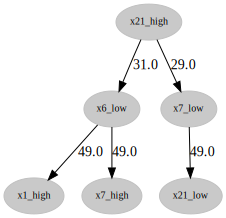

In [44]:
graph_simple(df_result_50)

In [ ]:
te_matrix44_novo = transferEntropy_case(dist6_novo_alm_mean5, 50,4,4)

trans  x21_low x1_low


In [51]:
print(_)

digraph {
	x21_high [label=x21_high color=gray fillcolor="#c9c9c9" fontsize=10 shape=oval style=filled width=0]
	x6_low [label=x6_low color=gray fillcolor="#c9c9c9" fontsize=10 shape=oval style=filled width=0]
	x7_low [label=x7_low color=gray fillcolor="#c9c9c9" fontsize=10 shape=oval style=filled width=0]
	x1_high [label=x1_high color=gray fillcolor="#c9c9c9" fontsize=10 shape=oval style=filled width=0]
	x7_high [label=x7_high color=gray fillcolor="#c9c9c9" fontsize=10 shape=oval style=filled width=0]
	x21_low [label=x21_low color=gray fillcolor="#c9c9c9" fontsize=10 shape=oval style=filled width=0]
	x6_low -> x1_high [label=49.0 color=black style=""]
	x6_low -> x7_high [label=49.0 color=black style=""]
	x21_high -> x7_low [label=30.0 color=black style=""]
	x7_low -> x21_low [label=49.0 color=black style=""]
}


In [52]:
#---------dfs novos com k-4, l=4


#Janela de 20 min
df_te_new_44_33 = pd.DataFrame(te_matrix44_novo[0], columns = dist6_novo_alm.columns, index= dist6_novo_alm.columns)
df_te_lag_new_44_33 = pd.DataFrame(te_matrix44_novo[1], columns = dist6_novo_alm.columns, index= dist6_novo_alm.columns)

df_te_new_44_33.to_csv("resultados_defesa/df_te_novo33_k4l4.csv")
df_te_lag_new_44_33.to_csv("resultados_defesa/df_lags_novo33_k4l4.csv")

df_result_33_k4l4 = apply_methodlogy(df_te_new_44_33,df_te_lag_new_44_33, dist6_novo_alm_mean5)

/home/rute/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


here  x6_low x1_high
here  x6_low x7_high
here  x21_high x6_low
here  x21_high x7_low
here  x21_high x21_low


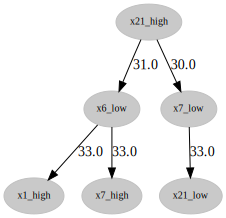

In [53]:
graph_simple(df_result_33_k4l4)

In [54]:
#Janela de 30 min
df_te_new_50_44 = pd.DataFrame(te_matrix44_novo[2], columns = dist6_novo_alm.columns, index= dist6_novo_alm.columns)
df_te_lag_new_50_44 = pd.DataFrame(te_matrix44_novo[3], columns = dist6_novo_alm.columns, index= dist6_novo_alm.columns)

#---------salvando te e lags----------
df_te_new_50_44.to_csv("resultados_defesa/df_te_novo50_k4l4.csv")
df_te_lag_new_50_44.to_csv("resultados_defesa/df_lags_novo50_k4l4.csv")

df_result_50_k4l4 = apply_methodlogy(df_te_new_50_44,df_te_lag_new_50_44, dist6_novo_alm_mean5)

here  x6_low x1_high
here  x6_low x7_high
here  x21_high x7_low
here  x21_high x21_low


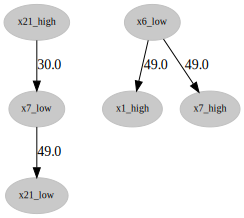

In [55]:
graph_simple(df_result_50_k4l4)

In [ ]:


#------------------janela de 30 min------------
t50 = np.mean(te_matrix[2]) + 3*np.std(te_matrix[2])


df_te_50 = pd.DataFrame(te_matrix[2], columns = dist6_novo_alm.columns, index= dist6_novo_alm.columns)
df_te_lag_50 = pd.DataFrame(te_matrix[3], columns = dist6_novo_alm.columns, index= dist6_novo_alm.columns)

#---------salvando te e lags----------
df_te_50.to_csv("resultados_defesa/df_te_novo50_k1l1.csv")
df_te_lag_50.to_csv("resultados_defesa/df_lags_novo50_k1l1.csv")

#aplicar threshold
te_k1l1_50 = generate_df_valid_corrs(df_te_50, t50)

#remover ciclos
te_50_no_cycle = pd.DataFrame (data = generate_aciclic_graph(te_k1l1_50.values), columns=te_k1l1_50.columns, index=te_k1l1_50.columns)

#passar a utilizar o grafo de lags ao invés do de TE

te_50_lags_no_cycle = df_te_lag_50[te_50_no_cycle > 0].fillna(0)

#computar todos os ancestrais (comuns e virtuais)

dict_ancestors_50 = get_all_shifts(te_50_lags_no_cycle.columns, te_50_lags_no_cycle)


#gerar arvore do k2
k2_50_tree = gen_tree_from_lags(dict_ancestors_50)

#gerar calcular k2

k2_result_50 = k2(dist6_novo_alm_mean5, k2_50_tree, te_50_lags_no_cycle, 0.7)

#reconstruir grafo

k2_rebuild_50 = gen_clean_df(te_50_lags_no_cycle, k2_result_50)

#trocar valores do k2 rebuild pelos lags corretos

graph_final_50 = te_50_lags_no_cycle[k2_rebuild_50>0].fillna(0)


In [ ]:
graph_simple(graph_final_50)

In [ ]:
# ### teste sintetico


# almNum = 3
# ocorr = 100
# t_sample = 60
# base_hour = dt.datetime(2018, 1,9,9,0,0)
# occor_num = 0

# #Settings alarms
# a = np.zeros(1, dtype=int)
# ocorr = 10
# duration = 120 #120sec
# hour_init = base_hour

# b = np.zeros(1, dtype=int)
# pAb =0.8
# delay_b = 60 #seconds
# duration_b = 120

# c = np.zeros(1, dtype=int)
# pAc = 0.9
# delay_c = 15 #seconds
# duration_c = 120

# #Alarm Series Generation, A (cause), B(Effect). C(Effect)
# while(occor_num < ocorr): 
    
#     #A generation - begin
#     srtd_hour = random.normalvariate(3, 1)
#     srtd_hour_begin = hour_init + dt.timedelta(hours=srtd_hour)
#     srtd_hour_end = srtd_hour_begin + dt.timedelta(seconds = duration)

#     idx_init_a_occor = int(math.ceil((srtd_hour_begin - base_hour).total_seconds()/t_sample))
#     idx_end_a_occor = int(math.ceil((srtd_hour_end - base_hour).total_seconds()/t_sample))
        
#     if(idx_end_a_occor > a.size):
#             a.resize(idx_end_a_occor)

#     for i in np.arange(idx_init_a_occor, idx_end_a_occor + 1):
#         a[i-1] = 1
#     #A generation - end
         
    
#     #B generation begin
#     srtd_prob_b = random.uniform(0,1)  
#     if srtd_prob_b <= pAb:
#         srtd_hour_begin_b = srtd_hour_begin + dt.timedelta(hours = delay_b/3600)
#         srtd_hour_end_b = srtd_hour_begin_b + dt.timedelta(seconds=duration_b)

#         idx_init_b_occor = int(math.ceil((srtd_hour_begin_b - base_hour).total_seconds()/t_sample))
#         idx_end_b_occor = int(math.ceil((srtd_hour_end_b - base_hour).total_seconds()/t_sample))

#         if(idx_end_b_occor > b.size):
#                 b.resize(idx_end_b_occor)

#         for j in np.arange(idx_init_b_occor, idx_end_b_occor +1):
#             b[j-1] =  1  

#     #B generation end

#     #C generation begin
#     srtd_prob_c = random.uniform(0,1)
#     if srtd_prob_c <= pAc:
#         srtd_hour_begin_c = srtd_hour_begin + dt.timedelta(hours = delay_b/3600)
#         srtd_hour_end_c = srtd_hour_begin_c + dt.timedelta(seconds=duration_c)

#         idx_init_c_occor = int(math.ceil((srtd_hour_begin_c - base_hour).total_seconds()/t_sample))
#         idx_end_c_occor = int(math.ceil((srtd_hour_end_c - base_hour).total_seconds()/t_sample))
        
#         if(idx_end_c_occor > c.size):
#             c.resize(idx_end_c_occor)

#         for j in np.arange(idx_init_c_occor, idx_end_c_occor +1):
#             c[j-1] = 1    
#     #C generation end
    
#     hour_init = srtd_hour_begin
#     occor_num = occor_num + 1

# #Making series the same length
# max_len = max(a, b, c, key=len).size
# a = np.concatenate([a, np.zeros(max_len - a.size)])
# b = np.concatenate([b, np.zeros(max_len - b.size)])
# c = np.concatenate([c, np.zeros(max_len - c.size)])

In [ ]:
[1,2,3,4,5,6][0:4]